# **Step 1: Scrape Data Using PRAW**

In [1]:
import praw
import pandas as pd
from datetime import datetime

# Reddit API credentials
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent=os.getenv("REDDIT_USER_AGENT")
)


# Function to scrape subreddit data
def scrape_reddit(subreddit_name, post_limit=5000, time_filter="week"):
    try:
        subreddit = reddit.subreddit(subreddit_name)
        posts = []
        for post in subreddit.top(time_filter=time_filter, limit=post_limit):
            posts.append({
                "title": post.title,
                "body": post.selftext,
                "score": post.score,
                "comments_count": post.num_comments,
                "created_at": datetime.fromtimestamp(post.created_utc),
            })
        return pd.DataFrame(posts)
    except Exception as e:
        print(f"Error while scraping: {e}")
        return pd.DataFrame()

# Scrape data from r/stocks subreddit
subreddit_data = scrape_reddit("stocks", post_limit=1000, time_filter="week")

# Save to CSV
subreddit_data.to_csv("reddit_stocks.csv", index=False)
print("Data saved to reddit_stocks.csv")


Data saved to reddit_stocks.csv


# **Step 2: Preprocess the Data(Clean)**

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Download stopwords (if not already done)
import nltk
nltk.download("stopwords")
nltk.download("punkt_tab")

stop_words = set(stopwords.words("english"))

# Text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply cleaning to the title and body
subreddit_data["cleaned_title"] = subreddit_data["title"].apply(clean_text)
subreddit_data["cleaned_body"] = subreddit_data["body"].apply(clean_text)

# Save cleaned data
subreddit_data.to_csv("reddit_stocks_cleaned.csv", index=False)
print("Cleaned data saved to reddit_stocks_cleaned.csv")


Cleaned data saved to reddit_stocks_cleaned.csv


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Step 3: Perform Sentiment Analysis**

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Initialize sentiment analyzer
nltk.download("vader_lexicon")
analyzer = SIA()

# Function to calculate sentiment score
def get_sentiment(text):
    if not text:
        return 0
    sentiment = analyzer.polarity_scores(text)
    return sentiment["compound"]

# Apply sentiment analysis
subreddit_data["title_sentiment"] = subreddit_data["cleaned_title"].apply(get_sentiment)
subreddit_data["body_sentiment"] = subreddit_data["cleaned_body"].apply(get_sentiment)

# Save data with sentiment scores
subreddit_data.to_csv("reddit_stocks_sentiment.csv", index=False)
print("Sentiment scores saved to reddit_stocks_sentiment.csv")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment scores saved to reddit_stocks_sentiment.csv


# **Step 4: Feature Engineering**
# (sentiment score, post scores and frequency of stock symbol)

In [4]:
def extract_stock_mentions(text):
    if not text:
        return []
    return re.findall(r"\$[A-Za-z]+", text)

# Extract stock mentions
subreddit_data["stock_mentions"] = subreddit_data["cleaned_title"].apply(extract_stock_mentions)

# Save data with features
subreddit_data.to_csv("reddit_stocks_features.csv", index=False)
print("Features saved to reddit_stocks_features.csv")


Features saved to reddit_stocks_features.csv


# **Step 5: Import Historical stock price data**

In [5]:
import yfinance as yf

# Fetch historical stock prices for a target stock
stock_data = yf.download("AAPL", start="2024-07-01", end="2024-12-01")

# Save stock price data
stock_data.to_csv("historical_stock_prices.csv")
print("Stock data saved to historical_stock_prices.csv")


[*********************100%***********************]  1 of 1 completed

Stock data saved to historical_stock_prices.csv


# **Step 6: Prepare data for Training**

In [7]:
# Create labels based on stock price movements
stock_data["price_change"] = stock_data["Close"].pct_change()
stock_data["label"] = (stock_data["price_change"] > 0).astype(int)  # 1 if price went up, 0 if down

# Merge stock data with Reddit data (make sure dates align)
# Note: You'll need to adjust for date alignment (e.g., using datetime or resampling).
print(stock_data['label'])

Date
2024-07-01    0
2024-07-02    1
2024-07-03    1
2024-07-05    1
2024-07-08    1
             ..
2024-11-22    1
2024-11-25    1
2024-11-26    1
2024-11-27    0
2024-11-29    1
Name: label, Length: 107, dtype: int64


# **Step 7.1:Train Machine Learning Model**
# (using linear Regression)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Test Logistic Regression
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.56      0.82      0.67        11

    accuracy                           0.55        20
   macro avg       0.53      0.52      0.49        20
weighted avg       0.53      0.55      0.51        20



# **Step 7.1:Train Machine Learning Model**
# (using Random Forest Classifier)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
n=len(subreddit_data)
random_rows = stock_data['label'].sample(n, random_state=42)
# Prepare features and labels
X = subreddit_data[["title_sentiment", "body_sentiment", "score", "comments_count"]]

y = stock_data['label'].tail(n)


# # Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# # Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.54      0.64      0.58        11

    accuracy                           0.50        20
   macro avg       0.48      0.48      0.48        20
weighted avg       0.49      0.50      0.49        20



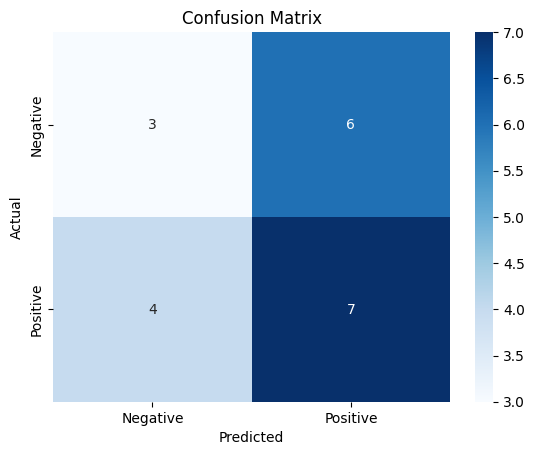

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
